In [15]:
# Setup paths and imports
from pathlib import Path
import json
import math
import shutil
import time
import warnings
warnings.filterwarnings('ignore')

base = Path('.').resolve()
data_path = base / 'data' / 'uybor_clean.csv'
models_dir = base / 'models'
report_dir = base / 'report'
graphs_dir = report_dir / 'graphs'
metrics_path = models_dir / 'metrics.json'
preds_path = models_dir / 'predictions.csv'
model_path = models_dir / 'model_lgb_log.joblib'

# Ensure output directories exist (important in Colab or fresh environments)
models_dir.mkdir(parents=True, exist_ok=True)
report_dir.mkdir(parents=True, exist_ok=True)
graphs_dir.mkdir(parents=True, exist_ok=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

print('Base:', base)
print('Data path:', data_path)


Base: C:\Users\RGB\Desktop\New folder (2)\DM
Data path: C:\Users\RGB\Desktop\New folder (2)\DM\data\uybor_clean.csv


In [16]:
# 1) Clean old graphs (remove existing files in report/graphs)
graphs_dir.mkdir(parents=True, exist_ok=True)
removed = 0
for f in graphs_dir.glob('*'):
    try:
        if f.is_file():
            f.unlink()
            removed += 1
        elif f.is_dir():
            shutil.rmtree(f)
            removed += 1
    except Exception as e:
        print('Warning removing', f, e)
print(f'Removed {removed} files from {graphs_dir}')


Removed 0 files from C:\Users\RGB\Desktop\New folder (2)\DM\report\graphs


In [17]:
# 2) Load data and prepare features/target
df = pd.read_csv(data_path)
print('Data shape:', df.shape)
features = ['rooms','size','level','max_levels','lat','lng','price_per_sqm']
X = df[features].copy()
X = X.fillna(-1)
y = np.log1p(df['price'])

# quick train/val split (20% val)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train/val:', X_train.shape, X_val.shape)


Data shape: (7421, 10)
Train/val: (5936, 7) (1485, 7)


In [18]:
# 3) Train model (LightGBM preferred, sklearn fallback)
num_rounds = 1000
sample_frac = 1.0
try:
    import lightgbm as lgb
    use_lgb = True
except Exception:
    use_lgb = False

if use_lgb:
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'verbose': -1,
        'seed': 42
    }
    print('Training LightGBM...')
    bst = lgb.train(params, train_data, num_boost_round=num_rounds, valid_sets=[val_data], callbacks=[lgb.early_stopping(50)])
    pred_log = bst.predict(X_val, num_iteration=bst.best_iteration)
    joblib.dump(bst, model_path)
else:
    print('LightGBM not available — using sklearn HistGradientBoostingRegressor')
    from sklearn.ensemble import HistGradientBoostingRegressor
    model = HistGradientBoostingRegressor(max_iter=max(10, num_rounds), random_state=42)
    model.fit(X_train, y_train)
    pred_log = model.predict(X_val)
    joblib.dump(model, model_path)

# back-transform predictions
pred = np.expm1(pred_log)
y_true = np.expm1(y_val)
rmse = math.sqrt(mean_squared_error(y_true, pred))
try:
    r2 = float(r2_score(y_true, pred))
except Exception:
    r2 = None
print(f'Log-target model RMSE (val): {rmse:.2f}')

# Save validation dataframe with features + preds so diagnostics can run
val_df = X_val.reset_index(drop=True).copy()
val_df['y_true'] = y_true.reset_index(drop=True)
val_df['y_pred'] = pred
val_df.to_csv(preds_path, index=False)

# Write metrics.json
metrics = {'rmse': float(rmse), 'r2': r2, 'n_train': int(len(X_train)), 'n_test': int(len(X_val))}
with open(metrics_path, 'w', encoding='utf-8') as fh:
    json.dump(metrics, fh, indent=2)
print('Saved artifacts:', preds_path, metrics_path)


LightGBM not available — using sklearn HistGradientBoostingRegressor
Log-target model RMSE (val): 6386.42
Saved artifacts: C:\Users\RGB\Desktop\New folder (2)\DM\models\predictions.csv C:\Users\RGB\Desktop\New folder (2)\DM\models\metrics.json
Log-target model RMSE (val): 6386.42
Saved artifacts: C:\Users\RGB\Desktop\New folder (2)\DM\models\predictions.csv C:\Users\RGB\Desktop\New folder (2)\DM\models\metrics.json


In [19]:
# 4) Diagnostics: residuals, residuals vs pred, group RMSEs, save preds_describe.csv
p = pd.read_csv(preds_path)
p['residual'] = p['y_true'] - p['y_pred']
p['abs_err'] = p['residual'].abs()
mse = mean_squared_error(p['y_true'], p['y_pred'])
rmse = math.sqrt(mse)
r2v = r2_score(p['y_true'], p['y_pred'])
print(f'Overall RMSE: {rmse:.2f}, R2: {r2v:.4f}')

# plots
sns.histplot(p['residual'], bins=60, kde=True)
plt.title('Residuals distribution')
plt.savefig(report_dir / 'residuals_hist.png', dpi=150)
plt.clf()

sns.scatterplot(x='y_pred', y='residual', data=p, alpha=0.3, s=10)
plt.axhline(0, color='red', linewidth=1)
plt.title('Residuals vs Predicted')
plt.savefig(report_dir / 'residuals_vs_pred.png', dpi=150)
plt.clf()

if 'district' in p.columns:
    grp = p.groupby('district').apply(lambda g: math.sqrt(mean_squared_error(g['y_true'], g['y_pred'])))
    print('Top districts by RMSE:')
    print(grp.sort_values(ascending=False).head(10))
else:
    print('No district column in predictions')

if 'size' in p.columns:
    try:
        p['size_q'] = pd.qcut(p['size'].rank(method='first'), q=5, labels=False)
        print('RMSE by size quantile:')
        print(p.groupby('size_q').apply(lambda g: math.sqrt(mean_squared_error(g['y_true'], g['y_pred']))))
    except Exception as e:
        print('Warning computing size quantiles:', e)
else:
    print('No size column in predictions')

summary_cols = [c for c in ['y_true','y_pred','residual','abs_err','rooms','size'] if c in p.columns]
if summary_cols:
    p[summary_cols].describe().to_csv(report_dir / 'preds_describe.csv')
    print('Saved preds_describe.csv')


Overall RMSE: 6386.42, R2: 0.9778
No district column in predictions
RMSE by size quantile:
size_q
0    12619.591653
1      829.271783
2      482.728384
3     2901.713902
4     5944.510813
dtype: float64
Saved preds_describe.csv
No district column in predictions
RMSE by size quantile:
size_q
0    12619.591653
1      829.271783
2      482.728384
3     2901.713902
4     5944.510813
dtype: float64
Saved preds_describe.csv


<Figure size 640x480 with 0 Axes>

In [20]:
# 5) Generate textual run summary (similar to scripts/generate_run_summary.py)
ts = time.strftime('%Y%m%d_%H%M%S')
summary_file = report_dir / f'results_summary_inline_{ts}.txt'
mse_val = mean_squared_error(p['y_true'], p['y_pred'])
with open(summary_file, 'w', encoding='utf-8') as fh:
    fh.write(f'Run timestamp: {ts}\n')
    fh.write(f'Data file: {data_path}\n')
    fh.write(f'Data shape: {df.shape[0]} rows, {df.shape[1]} columns\n\n')
    fh.write('=== Metrics ===\n')
    fh.write(f'Computed from: {preds_path}\n')
    fh.write(f"R^2: {metrics['r2'] if metrics['r2'] is not None else 'NA'}\n")
    fh.write(f"MSE: {mse_val:.4f}\n")
    fh.write(f"RMSE: {math.sqrt(mse_val):.4f}\n\n")
    fh.write('=== How results were produced ===\n')
    fh.write('Libraries: pandas, numpy, matplotlib, seaborn, scikit-learn, joblib\n')
    fh.write('Training: inline notebook (LightGBM or sklearn fallback)\n')
    fh.write('Plots: generated with seaborn/matplotlib and saved to report/\n')
print('Wrote textual summary to', summary_file)

Wrote textual summary to C:\Users\RGB\Desktop\New folder (2)\DM\report\results_summary_inline_20251202_104436.txt


In [21]:
# 6) Create combined summary image (report/summary_plot.png)
out_png = report_dir / 'summary_plot.png'
sns.set_theme(style='whitegrid')
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(2,2,1)
sns.histplot(p['residual'], bins=60, kde=True, ax=ax1)
ax1.set_title('Residuals distribution')
ax2 = fig.add_subplot(2,2,2)
sns.scatterplot(x=p['y_pred'], y=p['residual'], alpha=0.4, s=10, ax=ax2)
ax2.axhline(0, color='red', linewidth=1)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Residual')
ax2.set_title('Residuals vs Predicted')
ax3 = fig.add_subplot(2,1,2)
sns.scatterplot(x=p['y_true'], y=p['y_pred'], alpha=0.4, s=10, ax=ax3)
lims = [min(p['y_true'].min(), p['y_pred'].min()), max(p['y_true'].max(), p['y_pred'].max())]
ax3.plot(lims, lims, '--', color='gray')
ax3.set_xlim(lims)
ax3.set_ylim(lims)
ax3.set_xlabel('True')
ax3.set_ylabel('Predicted')
ax3.set_title('Predicted vs True')
metrics_text = f'RMSE: {metrics["rmse"]:.2f}\n'
if metrics['r2'] is not None:
    metrics_text += f'R^2: {metrics["r2"]:.4f}\n'
metrics_text += f'N: {len(p)}'
fig.text(0.02, 0.95, metrics_text, fontsize=10, verticalalignment='top')
plt.tight_layout(rect=[0,0,1,0.95])
out_png.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_png, dpi=150)
plt.close(fig)
print('Wrote summary image:', out_png)

Wrote summary image: C:\Users\RGB\Desktop\New folder (2)\DM\report\summary_plot.png


{
  "rmse": 6386.422539242733,
  "r2": 0.9778137752259078,
  "n_train": 5936,
  "n_test": 1485
}


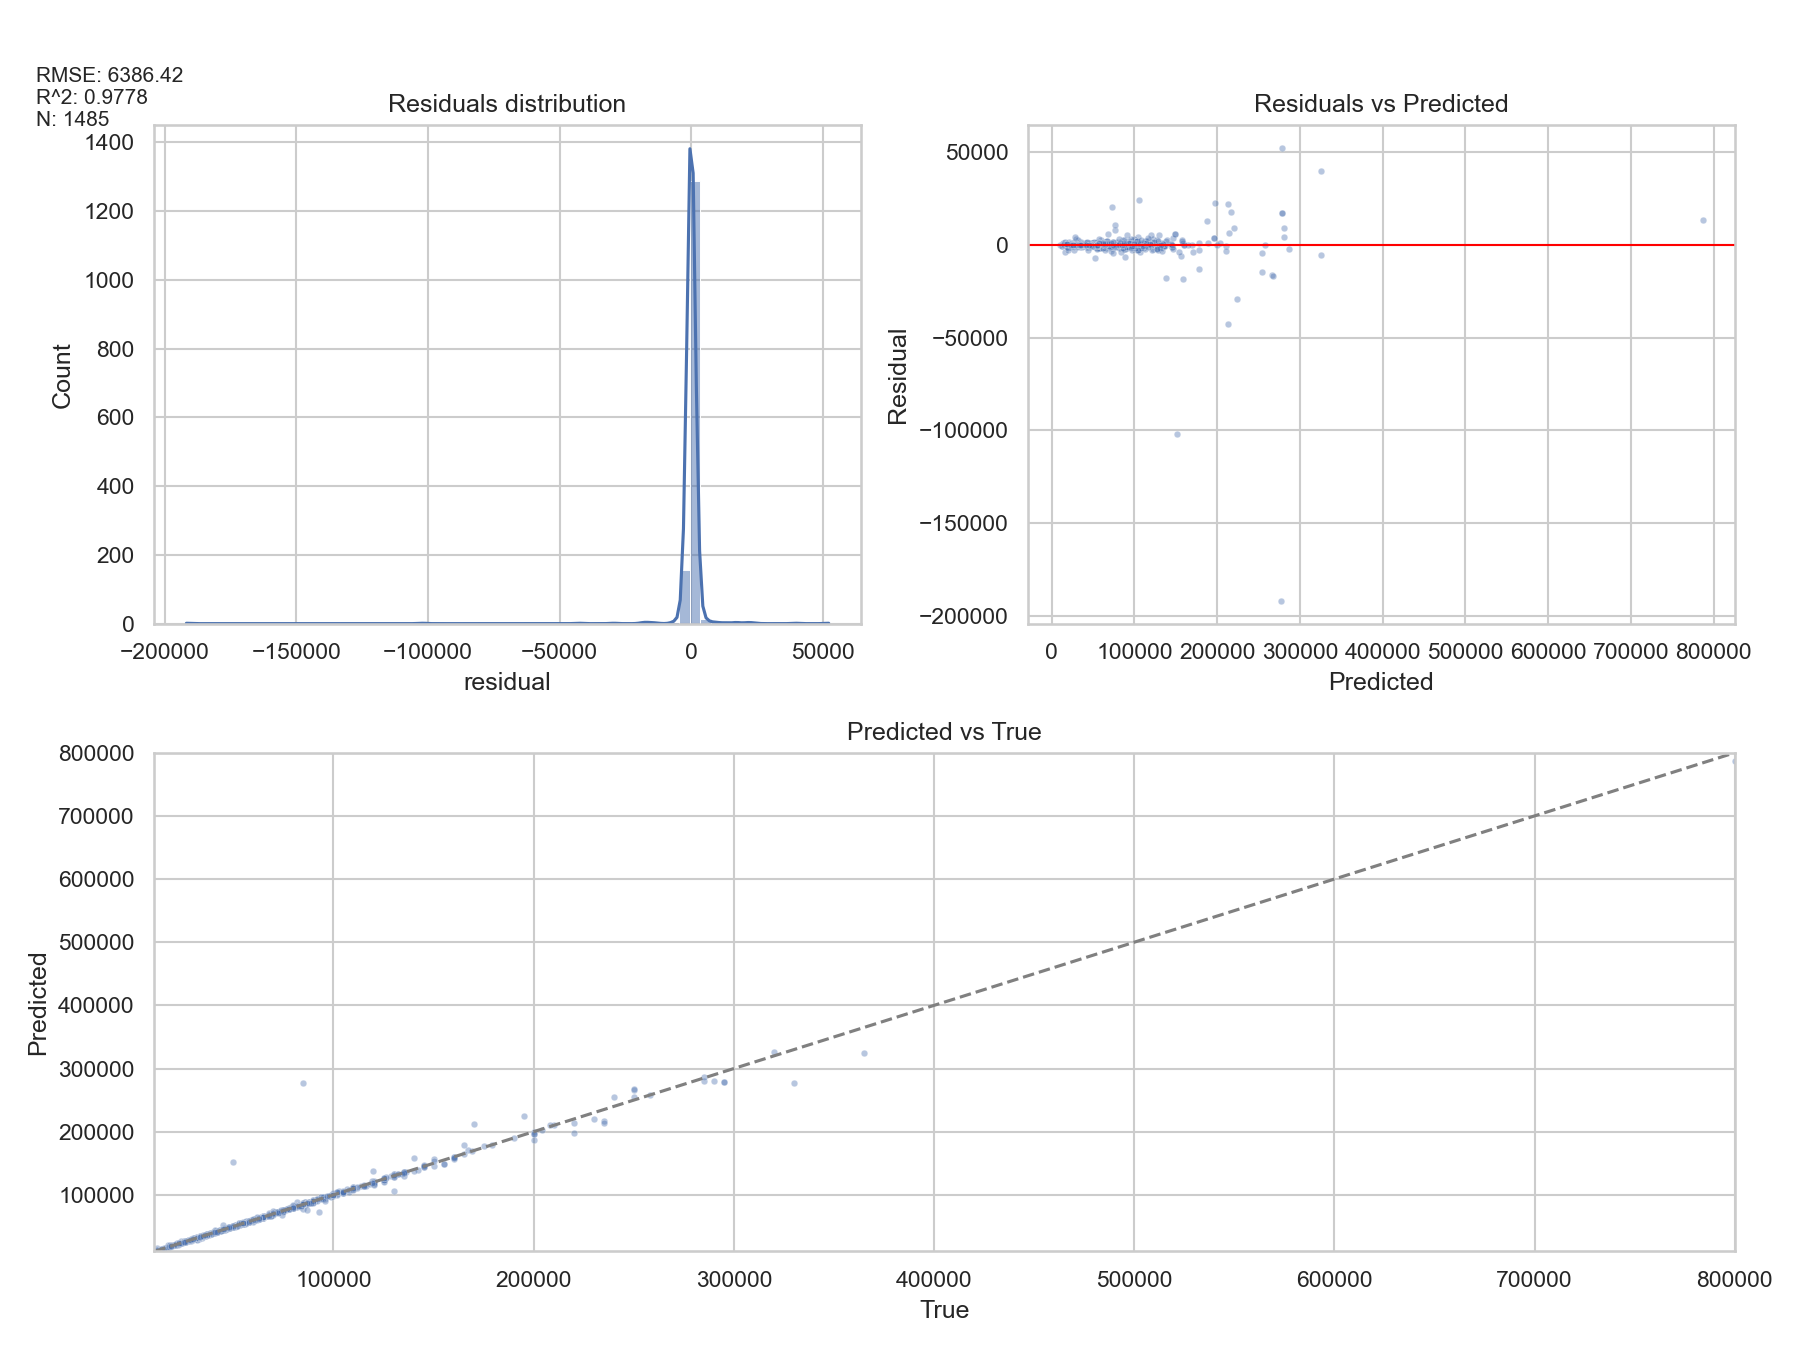

In [22]:
# 7) Show metrics and image in-notebook
from IPython.display import Image, display
print(json.dumps(metrics, indent=2))
img = report_dir / 'summary_plot.png'
if img.exists():
    display(Image(str(img)))
else:
    print('summary image not found')


Saved line plot to C:\Users\RGB\Desktop\New folder (2)\DM\report\prediction_vs_original_line.png


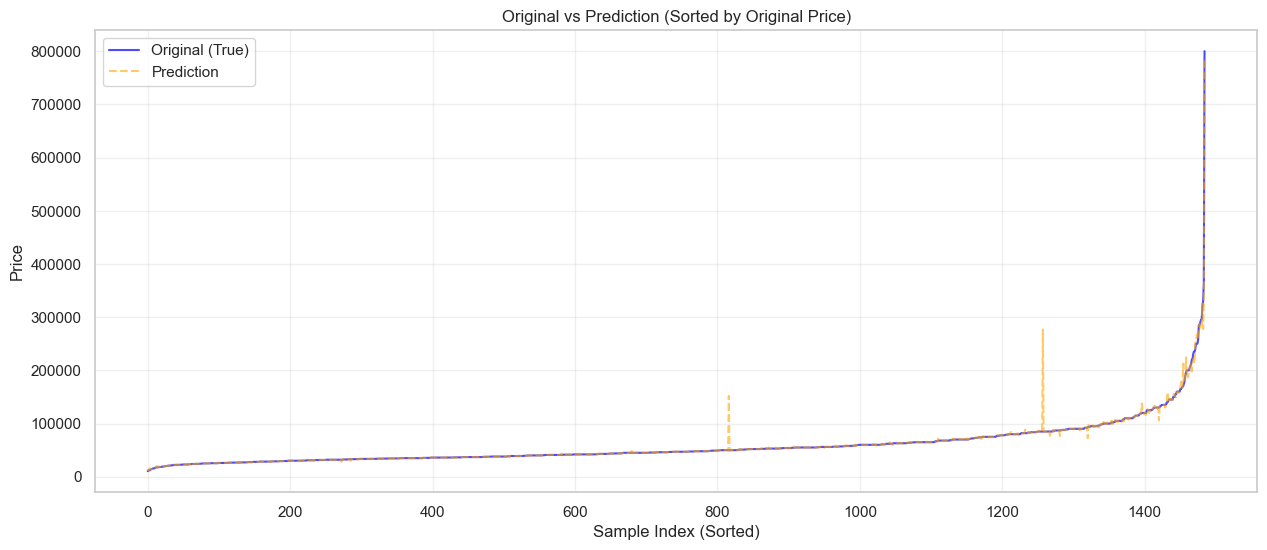

In [23]:
# 8) Line graph: Predicted vs True (Sorted)
import matplotlib.pyplot as plt
import seaborn as sns

# Reload just in case, or use existing 'p'
if 'p' not in locals():
    p = pd.read_csv(preds_path)

# Sort by actual value for clearer visualization
p_sorted = p.sort_values('y_true').reset_index(drop=True)

plt.figure(figsize=(15, 6))
plt.plot(p_sorted['y_true'], label='Original (True)', alpha=0.7, color='blue')
plt.plot(p_sorted['y_pred'], label='Prediction', alpha=0.6, linestyle='--', color='orange')
plt.title('Original vs Prediction (Sorted by Original Price)')
plt.xlabel('Sample Index (Sorted)')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)

line_plot_path = report_dir / 'prediction_vs_original_line.png'
plt.savefig(line_plot_path, dpi=150)
print(f"Saved line plot to {line_plot_path}")
plt.show()

Saved enhanced plot to C:\Users\RGB\Desktop\New folder (2)\DM\report\pred_true_enhanced.png (outliers=21, RMSE=6386.42)


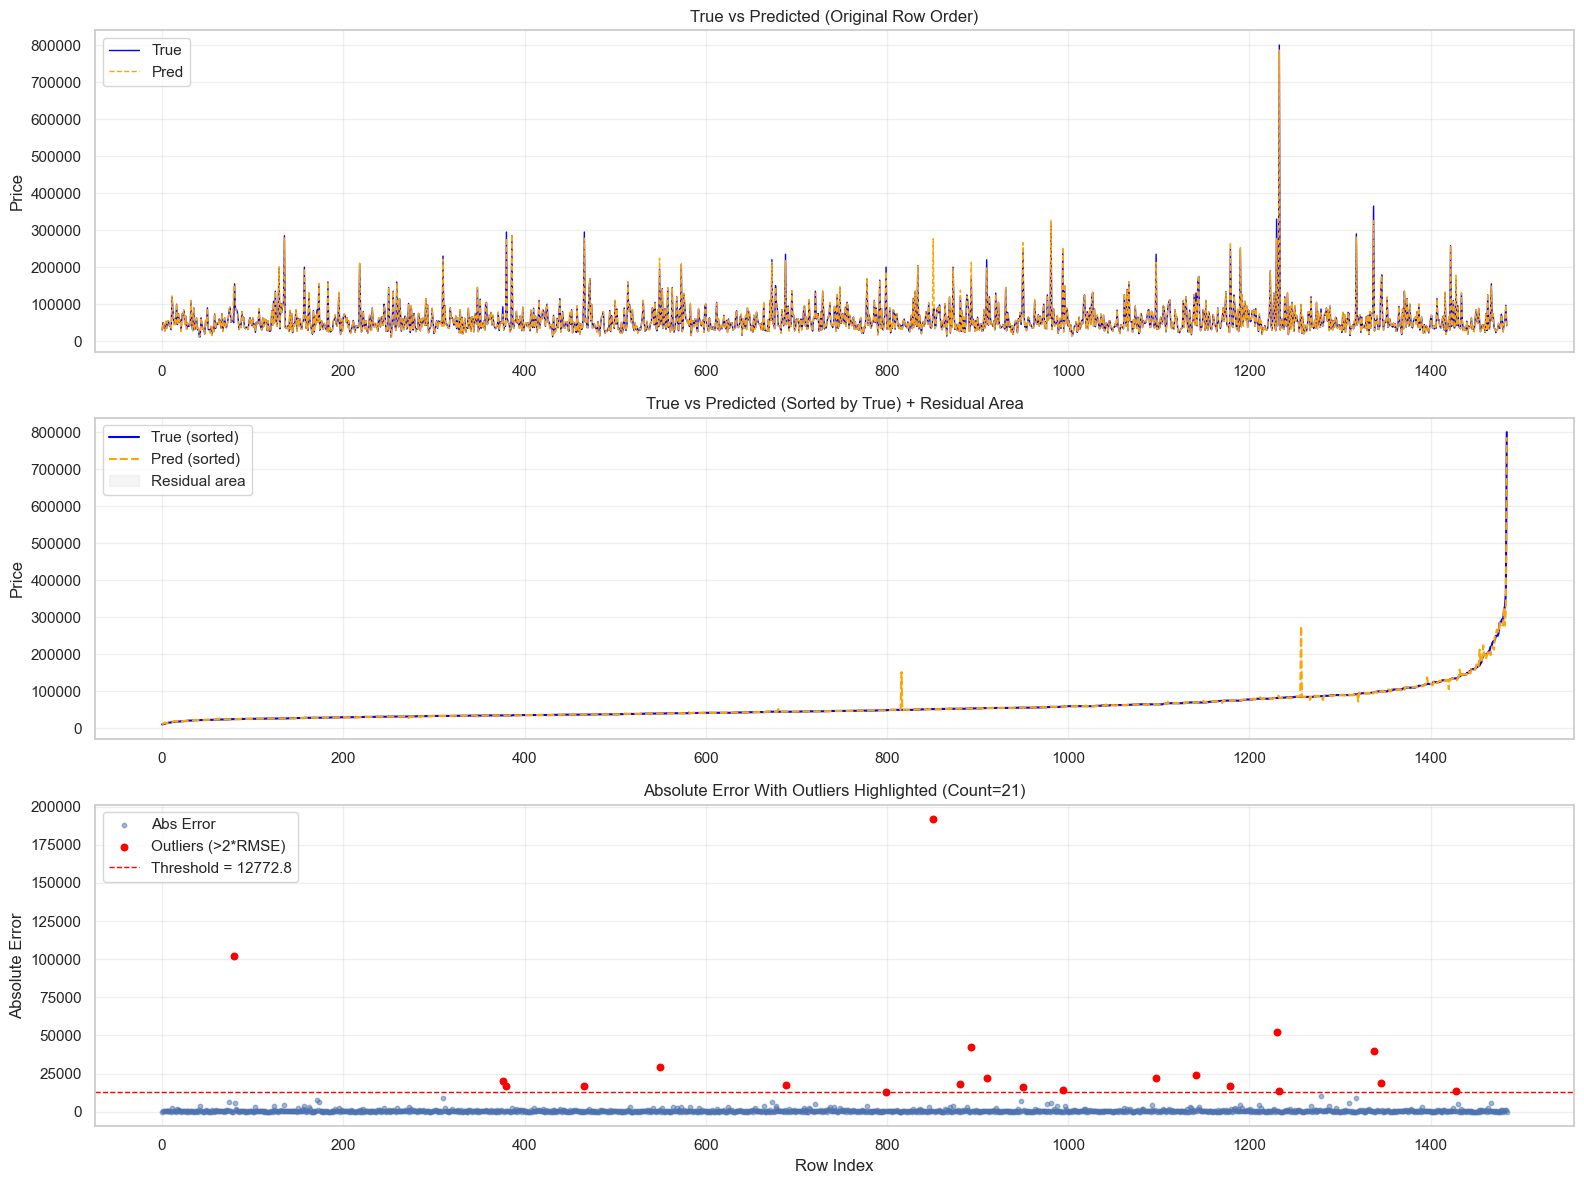

In [24]:
# 9) Enhanced comparative & outlier visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure predictions dataframe p is loaded
if 'p' not in locals():
    p = pd.read_csv(preds_path)
    if 'residual' not in p.columns:
        p['residual'] = p['y_true'] - p['y_pred']
        p['abs_err'] = p['residual'].abs()

rmse_line = math.sqrt(mean_squared_error(p['y_true'], p['y_pred']))
err_threshold = 2 * rmse_line  # configurable multiplier
outlier_mask = p['abs_err'] > err_threshold
num_outliers = outlier_mask.sum()

# Figure layout
fig = plt.figure(figsize=(16, 12))

# (A) Unsorted overlay
axA = fig.add_subplot(3,1,1)
axA.plot(p['y_true'].values, label='True', color='blue', linewidth=1)
axA.plot(p['y_pred'].values, label='Pred', color='orange', linestyle='--', linewidth=1)
axA.set_title('True vs Predicted (Original Row Order)')
axA.set_ylabel('Price')
axA.legend(loc='upper left')
axA.grid(alpha=0.3)

# (B) Sorted by true with residual shading
p_sorted2 = p.sort_values('y_true').reset_index(drop=True)
axB = fig.add_subplot(3,1,2)
axB.plot(p_sorted2['y_true'], label='True (sorted)', color='blue')
axB.plot(p_sorted2['y_pred'], label='Pred (sorted)', color='orange', linestyle='--')
# Residual band fill
residuals_sorted = p_sorted2['y_pred'] - p_sorted2['y_true']
axB.fill_between(range(len(p_sorted2)), p_sorted2['y_true'], p_sorted2['y_pred'], color='gray', alpha=0.08, label='Residual area')
axB.set_title('True vs Predicted (Sorted by True) + Residual Area')
axB.set_ylabel('Price')
axB.legend(loc='upper left')
axB.grid(alpha=0.3)

# (C) Outlier emphasis scatter
axC = fig.add_subplot(3,1,3)
axC.scatter(np.arange(len(p)), p['abs_err'], s=10, alpha=0.5, label='Abs Error')
axC.scatter(np.where(outlier_mask)[0], p.loc[outlier_mask, 'abs_err'], s=22, color='red', label='Outliers (>2*RMSE)')
axC.axhline(err_threshold, color='red', linestyle='--', linewidth=1, label=f'Threshold = {err_threshold:.1f}')
axC.set_title(f'Absolute Error With Outliers Highlighted (Count={num_outliers})')
axC.set_xlabel('Row Index')
axC.set_ylabel('Absolute Error')
axC.legend(loc='upper left')
axC.grid(alpha=0.3)

plt.tight_layout()
plot_path = report_dir / 'pred_true_enhanced.png'
plt.savefig(plot_path, dpi=150)
print(f'Saved enhanced plot to {plot_path} (outliers={num_outliers}, RMSE={rmse_line:.2f})')
plt.show()


In [ ]:
# 10) Prediction helper: single or batch inference
import numpy as np
import pandas as pd
import joblib

REQUIRED_FEATURES = ['rooms','size','level','max_levels','lat','lng','price_per_sqm']

# Load trained model (LightGBM Booster or sklearn Estimator)
_model = joblib.load(model_path)

# Fallback for price_per_sqm if missing in input
_fallback_ppsqm = None
try:
    if 'df' in globals() and 'price_per_sqm' in df.columns:
        _fallback_ppsqm = float(df['price_per_sqm'].median())
except Exception:
    pass
if _fallback_ppsqm is None:
    _fallback_ppsqm = 1000.0  # safe neutral fallback if dataset not available


def _to_dataframe(input_data):
    """Normalize input into a DataFrame with REQUIRED_FEATURES columns."""
    if isinstance(input_data, dict):
        data_df = pd.DataFrame([input_data])
    elif isinstance(input_data, list) and (len(input_data) == 0 or isinstance(input_data[0], dict)):
        data_df = pd.DataFrame(input_data)
    elif isinstance(input_data, pd.DataFrame):
        data_df = input_data.copy()
    else:
        raise ValueError("input_data must be a dict, list[dict], or pandas DataFrame")

    # If price_per_sqm missing, fill with fallback
    if 'price_per_sqm' not in data_df.columns:
        data_df['price_per_sqm'] = _fallback_ppsqm

    # Ensure all required columns exist
    for c in REQUIRED_FEATURES:
        if c not in data_df.columns:
            data_df[c] = -1

    # Order columns and fill missing
    data_df = data_df[REQUIRED_FEATURES]
    data_df = data_df.fillna(-1)
    return data_df


def predict_price(input_data):
    """Predict price from raw features.

    Parameters
    ----------
    input_data: dict | list[dict] | pandas.DataFrame
        Must include features: rooms, size, level, max_levels, lat, lng, price_per_sqm
        If price_per_sqm is omitted, a fallback median is used.

    Returns
    -------
    np.ndarray of predicted prices (float)
    """
    X_in = _to_dataframe(input_data)

    # Predict log(price) then back-transform
    try:
        pred_log = _model.predict(X_in)
    except TypeError:
        # Some LightGBM boosters prefer numpy arrays
        pred_log = _model.predict(X_in.values)
    y_pred = np.expm1(pred_log)
    return y_pred

# Example usage
_example = {
    'rooms': 3,
    'size': 70.0,
    'level': 5,
    'max_levels': 9,
    'lat': 41.31,
    'lng': 69.24,
    # If you omit price_per_sqm, the function will use a fallback
    'price_per_sqm': _fallback_ppsqm
}
print('Example prediction:', float(predict_price(_example)[0]))
